In [1]:
import pydicom
from pydicom.data import get_testdata_file


In [5]:
import numpy as np
npar = np.array(ds.pixel_array )
npar.shape

(256, 256)

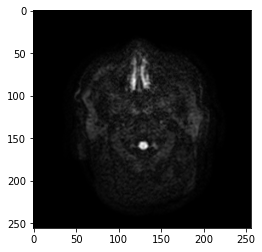

In [7]:
import matplotlib.pyplot as plt
plt.imshow(npar, cmap='gray')
plt.show()

In [3]:
from pathlib import Path
from collections import Counter

import pydicom
import numpy as np

import os
import sys

cntr = [0]
def progressBar(token, cnt, total, barLength=20):
    percent = float(cnt) * 100 / total
    arrow = '-' * int(percent / 100 * barLength - 1) + '>'
    spaces = ' ' * (barLength - len(arrow))
    sys.stdout.write('\rProcessing folder %s: Progress: [%s%s] %f %% ' % (
        token, arrow, spaces, percent))
    sys.stdout.flush()

def is_valid_slice(s):
    try:
        s.ImagePositionPatient
        assert s.SeriesDescription.count("DWI") != 0
        return True
    except:
        return False
def load_scan(path):
    path = Path(path)
    ##
    cntr[0]+=1
    progressBar(
        token=path.name,
        cnt=cntr[0],
        total=136
    )
    ##
    slices = [load_slice(s) for s in filter(os.path.isfile, path.iterdir())]
    slices = list(filter(is_valid_slice, slices))
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    return slices

def root_walk(rootfolder='.'):
    paths = Path(rootfolder)
    res = {}
    for p in paths.iterdir():
        if p.is_dir():
            res.update(root_walk(p))
    slcs = load_scan(rootfolder)
    tmp = {}
    for s in slcs:
        assert not s.PatientID in res
        if not s.PatientID in tmp:
            tmp[s.PatientID] = []
        tmp[s.PatientID].append(s)
    res.update(tmp)
    return res

def patient_image_index(rootfolder='.'):
    cntr[0] = 0
    return root_walk(rootfolder)

def load_slice(path):
    return pydicom.read_file(str(path))


def get_3d_image(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)

    return np.array(image, dtype=np.int16)



def filter_bad_slices(slices):
    spacings = Counter([s.PixelSpacing[0] for s in slices])
    common_spacing = spacings.most_common(1)[0][0]
    cleaned_slices = list(filter(lambda s: s.PixelSpacing[0]==common_spacing, slices))

    return cleaned_slices


In [4]:
d = patient_image_index('/home/jafar/PycharmProjects/CTstrokes/dicom/')

Processing folder dicom: Progress: [------------------->] 100.000000 % % 

# Data exploration

In [ ]:
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
from downloaddata import fetch_data as fdata
from myshow import myshow
import matplotlib.animation as animation

import numpy as np

In [20]:
import os
import nibabel as nib
import time
import numpy as np
from ipywidgets import interact, fixed
cdata = [None]
def explore(image_stack : list):
    plt.rcParams["figure.figsize"] = (20,10)
    def display_center_effect_3d(slice, cmap):
        
        type = cmap
        cmap = plt.cm.hot
        
        if type == 1:
            cmap = 'gray'
        x = image_stack[slice].pixel_array
        plt.imshow(x, cmap=cmap)
        plt.show()
    
    N = len(image_stack)
    interact(display_center_effect_3d, slice=(0,N-1), cmap=(0,1))
    
    
print(*list(d.keys()), sep='\n')


explore(d['200620618'])


200701504
200620618
200702479
150521635
110315815
200702481
130114658
080612051
150621772


interactive(children=(IntSlider(value=26, description='slice', max=53), IntSlider(value=0, description='cmap',…